<br>
# <strong>1 Introduction (Chapter 1)
<br>
## <strong>1 금융데이터 가공
by Google Finance

In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', family='NanumGothic')  # 한글폰트 사용

import numpy as np
import pandas as pd
from pandas_datareader import get_data_yahoo

goog = get_data_yahoo('005930.KS','2014-3-14','2017-12-1')
goog.index.name = u'Date'  # unicode String 문자를 사용
goog.tail(2)  

Open       High        Low      Close  Adj Close  Volume
Date                                                                     
2017-11-30  2540000.0  2593000.0  2510000.0  2540000.0  2540000.0  592683
2017-12-01  2540000.0  2589000.0  2540000.0  2542000.0  2542000.0  257372

[]

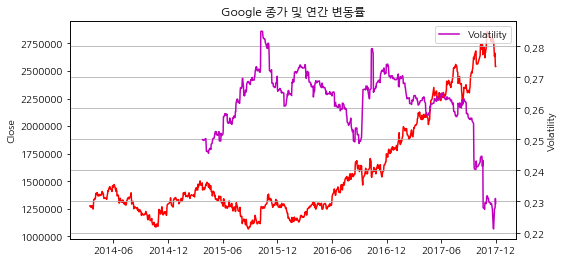

In [2]:
# 변동성 측정
goog['Log_Ret']    = np.log(goog['Close'] / goog['Close'].shift(1))            # 로그 변동값 변환 후
goog['Volatility'] = goog['Log_Ret'].rolling(window=252).std() * np.sqrt(252)  # 252일 평균 변동성 시각화

# 개별 Map을 그린다
fig, ax1 = plt.subplots(figsize=(8,4))
plt.plot(goog['Close'], 'r', lw=1.5); plt.ylabel('Close')

ax2 = ax1.twinx()
plt.plot(goog['Volatility'], 'm');    plt.ylabel('Volatility')
plt.legend(); plt.grid();plt.title('Google 종가 및 연간 변동률'); plt.plot()

<br>
## <strong>2 최대 성능 활용하기
Paradigm

In [3]:
# numexpr Thread 모두 활성화
import numpy as np
import numexpr as ne
ne.set_num_threads(4)

a, b = np.arange(1e7), np.arange(1e7)                    # 1,000,000 (백만)개 레이어 연산
%time print(ne.evaluate("a + b + 1"))                    # 간단한 수식의 연산 (사칙연산)
%time print('\n', ne.evaluate('a*b-4.1*a > 2.5*b'))      # 복잡한 판단문의 연산 (Boolean)
%time print('\n', ne.evaluate("sin(a) + arcsinh(a/b)"))  # 수학적 함수도 실행가능

[  1.00000000e+00   3.00000000e+00   5.00000000e+00 ...,   1.99999950e+07
   1.99999970e+07   1.99999990e+07]
CPU times: user 52.5 ms, sys: 10.2 ms, total: 62.7 ms
Wall time: 19.1 ms

 [False False False ...,  True  True  True]
CPU times: user 65.5 ms, sys: 746 µs, total: 66.2 ms
Wall time: 18 ms

 [        nan  1.72284457  1.79067101 ...,  0.59306843  1.53134258
  1.87203823]
CPU times: user 747 ms, sys: 10.1 ms, total: 757 ms
Wall time: 204 ms


<br>
## <strong>3 몬테카를로 시뮬레이션
Monte Carlo Simulation

계산량이나 복잡도가 차원에 따라 선형적으로 증가하므로 고차원 문제를 해결에 용이

In [4]:
# 파라미터 설정
S0 = 100.
K = 105.
T = 1.0
r = 0.05
sigma = 0.2
M = 50
dt = T / M
I = 250000
#bsm_call_value(S0, K, T, r, sigma) # 유러피안 콜옵션 가격을 계산

### <strong>01 Numpy를 활용한 벡터화
Vectorization with NumPy <strong>(Monte Carlo valuation of European call options with NumPy)

In [5]:
# mcs_vector_numpy.py
import math
import numpy as np
from time import time
np.random.seed(20000); t0 = time()

S = np.zeros((M + 1, I))              # 경로 하나당 M개의 시간구간을 갖는 I개의 샘플경로를 생성
S[0] = S0
for t in range(1, M + 1):             # 모든 경로의 같은시간 구간에 대한 vector 연산 적용
    z = np.random.standard_normal(I)  # pseudorandom numbers
    S[t] = S[t-1] * np.exp((r-0.5*sigma**2) * dt + sigma * math.sqrt(dt) * z)
C0 = math.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0)) / I  # 몬테카를로 시뮬레이션
print("European Option Value %7.3f" % C0)
print("Duration in Seconds   %7.3f" % (time() - t0))

European Option Value   8.037
Duration in Seconds     0.824


### <strong>02 Visulaization
Graphical Analysis

Text(0,0.5,'index level')

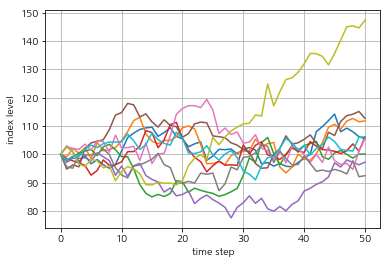

In [6]:
# 가격데이터중 10개를 시각화 비교를 한다
# Histogram of all simulated end of period index level valuesplt.hist(S[-1], bins=50)
import matplotlib.pyplot as plt
plt.plot(S[:, :10])
plt.grid(True)
plt.xlabel('time step')
plt.ylabel('index level')

Text(0,0.5,'frequency')

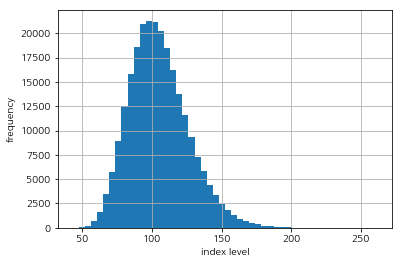

In [7]:
# 1개를 추출하여 'Histogram'을 그린다
# Histogram of all simulated end of period index level values
plt.hist(S[-1], bins=50)
plt.grid(True)
plt.xlabel('index level')
plt.ylabel('frequency')

133958

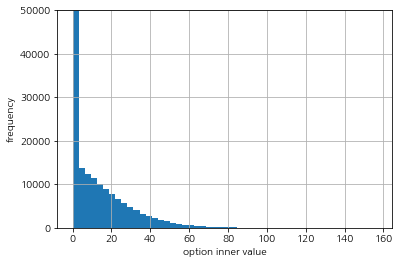

In [8]:
# 1개 추출한 옵션의 만기 내재가치
# 옵션은 만기에 가까울수록 가치가 줄어듬을 시각화로 증명한다
# Histogram of all simulated end of period option inner values
plt.hist(np.maximum(S[-1] - K, 0), bins=50)
plt.grid(True)
plt.xlabel('option inner value')
plt.ylabel('frequency')
plt.ylim(0, 50000)       # Y 영역을 0 ~ 50,000 으로 제한하여 시각화
sum(S[-1] < K)

<br>
## <strong>4 기술적 분석
과거 시장정보를 활용해, 미래의 주가방향을 예측
### <strong>01 데이터 읽기 및 추세선 계산하기
by Yahoo Finance 

cf) <strong>결과 Array</strong> = <strong>np.where</strong>(condition, True, False)  # 조건문 판단결과 

In [9]:
code = '006360.KS'
from pandas_datareader import get_data_yahoo
stock = get_data_yahoo(code,'2014-3-14','2017-12-1')
stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 916 entries, 2014-03-14 to 2017-12-01
Data columns (total 6 columns):
Open         916 non-null float64
High         916 non-null float64
Low          916 non-null float64
Close        916 non-null float64
Adj Close    916 non-null float64
Volume       916 non-null int64
dtypes: float64(5), int64(1)
memory usage: 50.1 KB


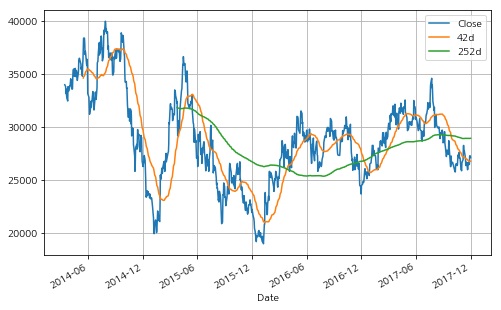

In [10]:
# 42일 , 252일 이동평균 데이터를 연산
stock['42d']  = np.round(stock['Close'].rolling(window=42).mean(), 2)
stock['252d'] = np.round(stock['Close'].rolling(window=252).mean(), 2)
stock[['Close', '42d', '252d']].plot(grid=True, figsize=(8, 5))

### <strong>02 매매 신호규칙 생성하기
매수/ 대기/ 매도신호를 42일추세와 252일추세로 추출
1. 매수신호(주식매수) : 42일 추세가, 252일 추세보다 <strong>SD만큼 위</strong>에 도달하였을때
1. 대기신호(현금보유) : 42일 추세가, 252일 추세 위/아래 <strong>SD값 사이</strong>에 있을때
1. 매도신호(주식공매도) : 42일 추세가, 252일 추세보다 <strong>SD만큼 아래</strong>에 도달하였을때

 1    356
-1    308
 0    252
Name: Regime, dtype: int64


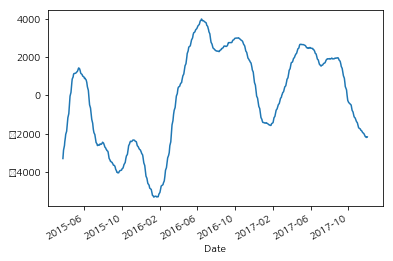

In [11]:
stock['42-252'] = stock['42d'] - stock['252d']
stock['42-252'].plot()

SD = 5
stock['Regime'] = np.where(stock['42-252'] >  SD,  1, 0)
stock['Regime'] = np.where(stock['42-252'] < -SD, -1, stock['Regime'])
print(stock['Regime'].value_counts())
# 42일 추세 위 : '1', 42일 추세 아래 : '-1', 42일 추세 위/아래 내부 해당 : '0'
# 위/아래를 교차하는 '0'이 '매매영역'이 된다

(-1.1, 1.1)

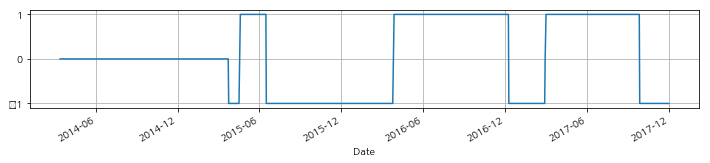

In [12]:
# Signal regimes over time
stock['Regime'].plot(lw=1.5, grid=True, figsize=(12,2))
plt.ylim([-1.1, 1.1])

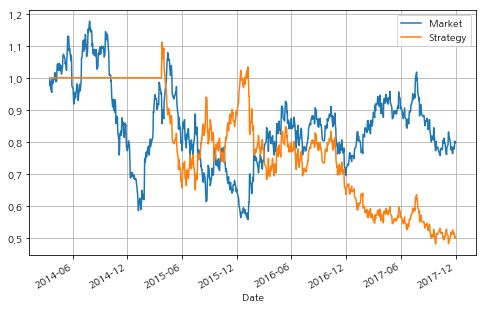

In [13]:
stock['Market']   = np.log(stock['Close'] / stock['Close'].shift(1))
stock['Strategy'] = stock['Regime'].shift(1) * stock['Market']
# The S&P 500 index vs. investor's wealth
stock[['Market', 'Strategy']].cumsum().apply(np.exp).plot(grid=True, figsize=(8, 5))

<br>
# <strong>2 Data Types and Structures (Chapter 4)
<br>
## <strong>1 시계열 자료형
### <strong>01 문자
<strong>by Regular Express

In [14]:
import re       # 정규식 모델
series = """'01/18/2014 13:00:00', 100, '1st'; '01/18/2014 13:30:00', 110, '2nd'; '01/18/2014 14:00:00', 120, '3rd'"""
dt = re.compile("'[0-9/:\s]+'") 
result = dt.findall(series)

from datetime import datetime             # %m %d %Y 의 포맷이 일치시 정상적 추출
pydt = datetime.strptime(result[0].replace("'", ""),  '%m/%d/%Y %H:%M:%S'); 
print('Regx Result : {} \nPydt Result : {} , {}'.format(result,pydt, type(pydt)))

Regx Result : ["'01/18/2014 13:00:00'", "'01/18/2014 13:30:00'", "'01/18/2014 14:00:00'"] 
Pydt Result : 2014-01-18 13:00:00 , <class 'datetime.datetime'>


<br>
## <strong>2 Numpy
ndarray : List 보다 다양하고, 복잡한 연산을 쉽게 수행가능
### <strong>01 Array
1차원 자료형

In [15]:
import numpy as np
a = np.array([0, 0.5, 1.0, 1.5, 2.0])
# Slicing 에 용이하다 : list와 동일
print(type(a)); a[:2]  
# 간단한 연산에 용이하다
print(a.sum())     # 객체의 총합
print(a.std())     # 객체의 표준편차
print(a.cumsum())  # 객체의 누적합
print(a * 2)
np.sqrt(a)         # Sequare : 제곱근 (벡터화된 수학연산도 가능)

<class 'numpy.ndarray'>
5.0
0.707106781187
[ 0.   0.5  1.5  3.   5. ]
[ 0.  1.  2.  3.  4.]


array([ 0.        ,  0.70710678,  1.        ,  1.22474487,  1.41421356])

### <strong>02 Array 
2차원 <strong>MATRIX</strong> 자료형

In [16]:
b = np.array([a , a * 2])
print('Data             :', b)
print('Data[0]          :', b[0])      # 첫 행
print('Data[0, 2]       :', b[0, 2])   # 첫 행, 두번째 객체 
print('Data.sum()       :', b.sum())
print('Data.sum(axis=0) :', b.sum(axis=0)) # 0번 축의 합
print('Data.sum(axis=1) :', b.sum(axis=1)) # 1번 축의 합 (row/ column 의 구분이 아니다!!!!)

Data             : [[ 0.   0.5  1.   1.5  2. ]
 [ 0.   1.   2.   3.   4. ]]
Data[0]          : [ 0.   0.5  1.   1.5  2. ]
Data[0, 2]       : 1.0
Data.sum()       : 15.0
Data.sum(axis=0) : [ 0.   1.5  3.   4.5  6. ]
Data.sum(axis=1) : [  5.  10.]


### <strong>03 ndarray
NOT-DEFINED-array : 특정한 원소값이 없이 생성을 시작한 객체

In [17]:
# np.ones()
# np.zeros_like()
c = np.zeros( (2, 3, 4), dtype='i'   , order='C')
d = np.ones_like(c,      dtype='f16' , order='C')
print('np.zeros() : {} \nnp.ones_like() : {}'.format(c,d))

np.zeros() : [[[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]

 [[0 0 0 0]
  [0 0 0 0]
  [0 0 0 0]]] 
np.ones_like() : [[[ 1.0  1.0  1.0  1.0]
  [ 1.0  1.0  1.0  1.0]
  [ 1.0  1.0  1.0  1.0]]

 [[ 1.0  1.0  1.0  1.0]
  [ 1.0  1.0  1.0  1.0]
  [ 1.0  1.0  1.0  1.0]]]


### <strong>04 ndarray 의 구조화 배열 (Structured Arrays)
SQL의 Table 생성과 유사하게, 개별 field의 '이름', '추가정보'를 지정한다

In [18]:
# DataType를 임의로 지정가능
dt = np.dtype([('Name', 'S10'), ('Age', 'i4'), ('Height', 'f'), ('Children/Pets', 'i4', 2)])
s  = np.array([('Smith',  45,  1.83,  (0, 1)), 
               ('Jones',  53,  1.72,  (2, 2))], dtype=dt)
# Name 필드의 데이터, S10 : string은 max 10개
print("s['Name']   : {}\ns['Height'] : {}\ns[1]['Age'] : {}".format(s['Name'],s['Height'].mean(),s[1]['Age']))
s

s['Name']   : [b'Smith' b'Jones']
s['Height'] : 1.7750000953674316
s[1]['Age'] : 53


array([(b'Smith', 45,  1.83000004, [0, 1]),
       (b'Jones', 53,  1.72000003, [2, 2])],
      dtype=[('Name', 'S10'), ('Age', '<i4'), ('Height', '<f4'), ('Children/Pets', '<i4', (2,))])

### <strong>05 벡터객체의 연산
Matrix 전체를 한번에 연산한다

In [19]:
r = np.random.standard_normal((4, 3))
s = np.random.standard_normal((4, 3))
2 * r + 3 + s

# 차원은 달라도, 브로드캐스팅이 가능한 객체수인 경우 연산이 진행
# cf) multiple로도 맞지 않으면 '브로드캐스팅'은 되지 않는다
r = np.random.standard_normal((2, 3))
s = np.random.standard_normal(3)
print(np.shape(r.T))
r + s

(3, 2)


array([[ 1.52150734, -0.56300135,  0.3816837 ],
       [ 2.27718108,  0.56601592,  0.26356566]])

In [20]:
def f(x):
    return 3 * x + 5
f(r)  # Matrix 객체에도 간단한 사칙연산이 적용

array([[ 5.39028964,  3.35984277,  6.70995309],
       [ 7.65731085,  6.74689456,  6.35559896]])

# <strong> 3 Visualization (Chapter 5)
matplotlib
<br>
## <strong>1 Line Chart
데이터 시각화 matplotlib_0
### <strong>01 1차원 data to plot
numpy.Array 

<img src="https://image.slidesharecdn.com/python08-150723163743-lva1-app6892/95/python-46-638.jpg" align='left' width='550'>

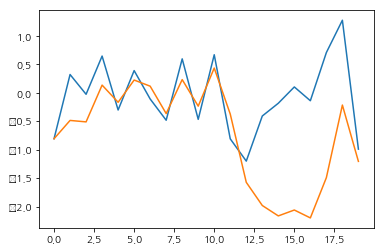

In [21]:
# x, y 좌표값으로 그래프 그리기
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1000)
y = np.random.standard_normal(20)
plt.plot(y)          # index 객체 없이, Y 로만 plot() 가능
plt.plot(y.cumsum()) # Y 로만 plot : cumsum()으로 객체의 값을 변환

(-3.1915310617211072, 1.4342209788376488)

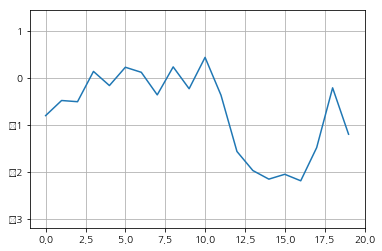

In [22]:
# 가독성 향상을 위해 x축 길이를 지정 : y 축은 1씩 여유값 지정
plt.plot(y.cumsum()); plt.grid(True)
plt.xlim(-1, 20)
plt.ylim(np.min(y.cumsum()) - 1, np.max(y.cumsum()) + 1)

Text(0.5,1,'A Simple Plot')

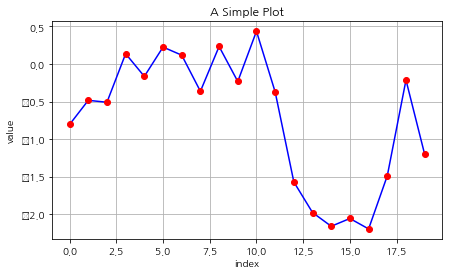

In [23]:
# Full setting Ploting.. (figsize = (너비, 높이))
plt.figure(figsize=(7, 4))
plt.plot(y.cumsum(), 'b', lw=1.5)  # 파란색 실선
plt.plot(y.cumsum(), 'ro')         # 해당 inde 마다 빨간 원 (red circle)
plt.grid(True)
plt.axis('tight')
plt.xlabel('index'); plt.ylabel('value'); plt.title('A Simple Plot')

### <STRONG>02  2차원 data to plot
numpy.Array 

In [24]:
# 2차원 배열을 생성
np.random.seed(2000)
y = np.random.standard_normal((20, 2)).cumsum(axis=0)
y.shape

(20, 2)

Text(0.5,1,'A Simple Plot')

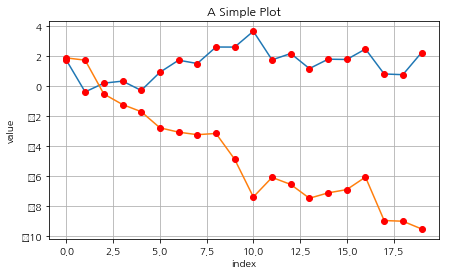

In [25]:
# y 객체 1개를 입력해도, 출력객체는 2개가 출력된다
plt.figure(figsize=(7, 4))
plt.plot(y, lw=1.5) # plots two lines
plt.plot(y, 'ro')   # plots two dotted lines (index 별 찍어준다)
plt.grid(True); plt.axis('tight')
plt.xlabel('index'); plt.ylabel('value'); plt.title('A Simple Plot')

Text(0.5,1,'A Simple Plot')

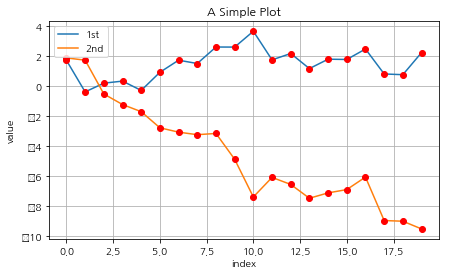

In [26]:
# 가독성 보완하기
# 다차원 배열객체를 나눠서 입력 및 개별 label을 정의
plt.figure(figsize=(7, 4))
plt.plot(y[:, 0], lw=1.5, label='1st')  
plt.plot(y[:, 1], lw=1.5, label='2nd')
plt.plot(y, 'ro')                        # red dot 을 index 별로 찍음
plt.grid(True); plt.legend(loc=0); plt.axis('tight')
plt.xlabel('index'); plt.ylabel('value'); plt.title('A Simple Plot')

Text(0,0.5,'value 2nd')

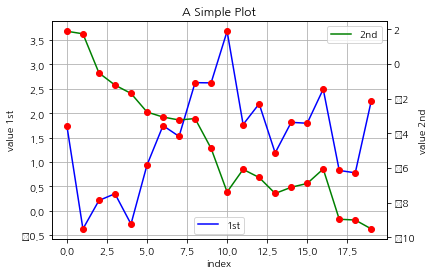

In [27]:
# 자료의 절대값이 크게 차이나는 경우, 변별력이 떨어진다
# 첫 자료를 첫번쨰 축(왼쪽축)에 대응하여 그린다
fig, ax1 = plt.subplots()
plt.plot(y[:, 0], 'b', lw=1.5, label='1st')
plt.plot(y[:, 0], 'ro')
plt.grid(True); plt.legend(loc=8); plt.axis('tight')
plt.xlabel('index'); plt.ylabel('value 1st'); plt.title('A Simple Plot')

# 두번쨰 자료를 두번쨰 축(오른쪽축)에 대응하여 그린다
ax2 = ax1.twinx()
plt.plot(y[:, 1], 'g', lw=1.5, label='2nd')
plt.plot(y[:, 1], 'ro')
plt.legend(loc=0); plt.ylabel('value 2nd') # 첫 그래프와 다른 부분만 정의

Text(0,0.5,'value')

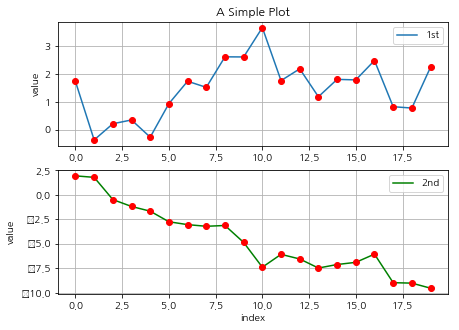

In [28]:
# 여러개의 Graph를 그릴떄 자유도 높은 설정방법
plt.figure(figsize=(7, 5)) # graph 1개의 크기를 정의

plt.subplot(211)           # row수, col수, fig위치값 (2X1 중 1번)
plt.plot(y[:, 0], lw=1.5, label='1st')
plt.plot(y[:, 0], 'ro')
plt.grid(True); plt.legend(loc=0); plt.axis('tight')
plt.ylabel('value'); plt.title('A Simple Plot')

plt.subplot(212)           # row수, col수, fig위치값 (2X1 중 2번)
plt.plot(y[:, 1], 'g', lw=1.5, label='2nd')
plt.plot(y[:, 1], 'ro')
plt.grid(True); plt.legend(loc=0); plt.axis('tight')
plt.xlabel('index'); plt.ylabel('value')

In [29]:
# 동일한 자료를 서로다른 방식으로 시각화
plt.figure(figsize=(9, 4))
plt.subplot(121)         # row수, col수, fig위치값 (1X2 중 1번)
plt.plot(y[:, 0], lw=1.5, label='1st')
plt.plot(y[:, 0], 'ro')
plt.grid(True); plt.legend(loc=0); plt.axis('tight')
plt.xlabel('index'); plt.ylabel('value'); plt.title('1st Data Set')

plt.subplot(122)         # row수, col수, fig위치값 (1X2 중 2번)
plt.bar(np.arange(len(y)), y[:, 1], width=0.5,
        color='g', label='2nd')
plt.grid(True); plt.legend(loc=0); plt.axis('tight')
plt.xlabel('index'); plt.title('2nd Data Set')

Text(0.5,1,'2nd Data Set')

<br>
## <strong>2 Scatter, Histogram, Boxplot
기타 plot 유형
### <strong>01 산포도
Scatter plot via +plot+ function

Text(0.5,1,'Scatter Plot')

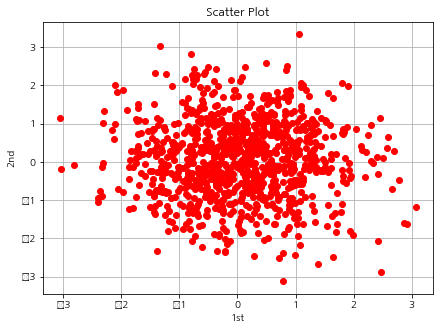

In [30]:
y = np.random.standard_normal((1000, 2))  # y.shape : 1000, 2 - 정규분포 데이터
# plot()를 활용해서 출력
plt.figure(figsize=(7, 5))
plt.plot(y[:, 0], y[:, 1], 'ro')  # 0번컬럼, 1번컬럼 을 축으로 그린다
plt.grid(True); plt.xlabel('1st'); plt.ylabel('2nd'); plt.title('Scatter Plot')

Text(0.5,1,'Scatter Plot')

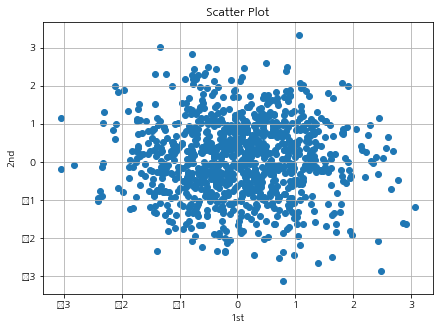

In [31]:
# scatter() 를 활용해서 출력
plt.figure(figsize=(7, 5))
plt.scatter(y[:, 0], y[:, 1], marker='o')
plt.grid(True); plt.xlabel('1st'); plt.ylabel('2nd'); plt.title('Scatter Plot')

Text(0.5,1,'Scatter Plot')

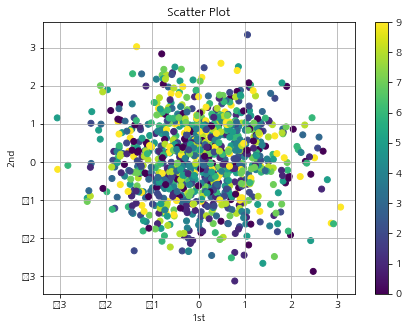

In [32]:
# 3차원 생성 (plt.colorbar() 입력값 추가)
c = np.random.randint(0, 10, len(y))  # 0~10 사이 정수를 , 1000개 추출
# Scatter plot with third dimension
plt.figure(figsize=(7, 5))
plt.scatter(y[:, 0], y[:, 1], c=c, marker='o')  # c : color
plt.colorbar()                                  # colorbar() 를 활용
plt.grid(True); plt.xlabel('1st'); plt.ylabel('2nd'); plt.title('Scatter Plot')

### <strong>02 히스토그램
Histogram : 금융자산의 '수익률'비교

Text(0.5,1,'Histogram')

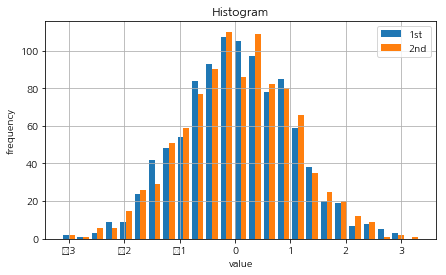

In [33]:
# 히스토그램 기본형
plt.figure(figsize=(7, 4))
plt.hist(y, label=['1st', '2nd'], bins=25)
plt.grid(True)     ;  plt.legend(loc=0)
plt.xlabel('value');  plt.ylabel('frequency');  plt.title('Histogram')

In [34]:
# 히스토그램 연속형 (stacked = True)
plt.figure(figsize=(7, 4))
plt.hist(y, label=['1st', '2nd'], color=['b', 'g'], stacked=True, bins=20)
plt.grid(True); plt.legend(loc=0)
plt.xlabel('value'); plt.ylabel('frequency'); plt.title('Histogram')

Text(0.5,1,'Histogram')

### <strong>03 Box Plot
집합의 특성을 동시에 정확하게 표현이 가능하다

In [35]:
fig, ax = plt.subplots(figsize=(7, 4))
plt.boxplot(y)
plt.grid(True)
plt.setp(ax, xticklabels=['1st', '2nd'])
plt.xlabel('data set'); plt.ylabel('value'); plt.title('Boxplot')

Text(0.5,1,'Boxplot')

### <strong>04 적분 면적과 라벨링
지수함수 그래프를 시각화

In [36]:
# 사용자 지수함수 정의뒤 이를 계산
from matplotlib.patches import Polygon
def func(x):
    return 0.5 * np.exp(x) + 1

a, b = 0.5, 1.5  # integral limits
x = np.linspace(0, 2)
y = func(x)

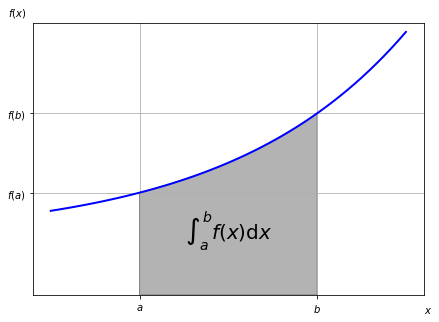

In [37]:
# 지수함수를 그린다
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(ymin=0)

# 특정영역에 색을 추가한다 (Polygon() 다각형을 그려넣기)
Ix = np.linspace(a, b)
Iy = func(Ix)
verts = [(a, 0)] + list(zip(Ix, Iy)) + [(b, 0)]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
ax.add_patch(poly)

# 영역 내부 수식을 추가(Mark Down)
plt.text(0.5 * (a + b), 1, r"$\int_a^b f(x)\mathrm{d}x$",
         horizontalalignment='center', fontsize=20)
plt.figtext(0.9, 0.075, '$x$')
plt.figtext(0.075, 0.9, '$f(x)$')

ax.set_xticks((a, b)); ax.set_xticklabels(('$a$', '$b$'))
ax.set_yticks([func(a), func(b)]); ax.set_yticklabels(('$f(a)$', '$f(b)$'))
plt.grid(True)

<br>
## <strong>3 Candle Stick Charts
https://stackoverflow.com/questions/42437349/candlestick-plot-from-a-pandas-dataframe

In [38]:
from pandas_datareader import get_data_yahoo
code  = '005930.KS'
start = '2014-5-1'
end   = '2014-6-30'
quote = get_data_yahoo(code, start, end)

In [39]:
# ["Date","Open","High",'Low',"Close"] 
import matplotlib.dates as mdates
quote = quote.reset_index()      # 날짜를 column으로 추출
df_ohlc = quote.iloc[:,:5]       # 캔들차트 필요자료만 추출

# dates 자료를 Time Stamp(float)로 변환
df_ohlc['Date'] = df_ohlc['Date'].map(mdates.date2num)
df_ohlc.head(2)

Date       Open       High        Low      Close
0  735353.0        NaN        NaN        NaN        NaN
1  735355.0  1343000.0  1359000.0  1343000.0  1346000.0

In [40]:
# 캔들차트를 시각화
import matplotlib.finance as mpf
fig, ax = plt.subplots(figsize=(8, 5))
mpf.candlestick_ohlc(ax, df_ohlc.values , width=0.6, colorup='r', colordown='b')
plt.grid(True)
ax.xaxis_date()  # x 축에 날짜를 추가한다
ax.autoscale_view()
fig.autofmt_xdate()

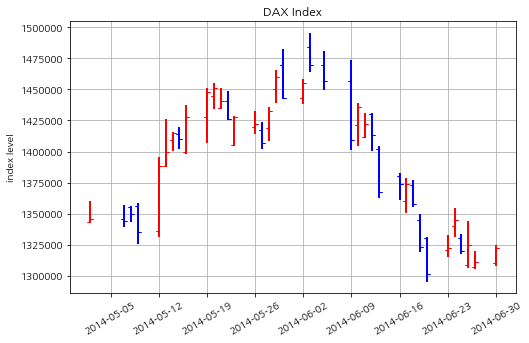

In [41]:
# 시가와 종가를 작은 수평선으로 표시
fig, ax = plt.subplots(figsize=(8, 5))
mpf.plot_day_summary_ohlc(ax, df_ohlc.values , colorup='r', colordown='b')
plt.grid(True)
ax.xaxis_date(); plt.title('DAX Index'); plt.ylabel('index level')
plt.setp(plt.gca().get_xticklabels(), rotation=30);

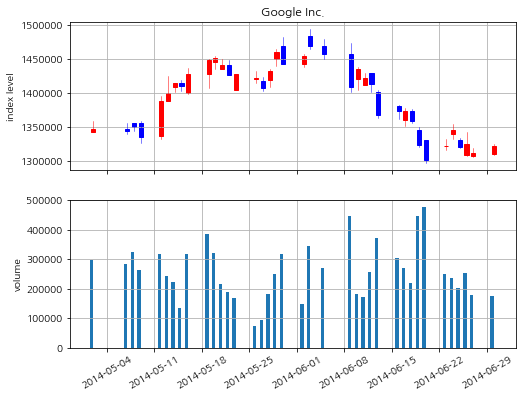

In [42]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(8, 6))
mpf.candlestick_ohlc(ax1, df_ohlc.values, width=0.6, colorup='r', colordown='b')
ax1.set_title('Google Inc.'); ax1.set_ylabel('index level')
ax1.grid(True);               ax1.xaxis_date()

plt.bar(df_ohlc.values[:, 0] - 0.25, quote.values[:, 6], width=0.5)
ax2.set_ylabel('volume');   ax2.grid(True)
ax2.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=30);

<br>
## <strong>4 3차원 plot
일반적으로 비교가 어려워 잘 사용하지 않지만, 내재 변동성을 확인하기 위해서 종종 활용한다

In [43]:
strike = np.linspace(50, 150, 24)
ttm = np.linspace(0.5, 2.5, 24)
strike, ttm = np.meshgrid(strike, ttm)
strike[:2]

array([[  50.        ,   54.34782609,   58.69565217,   63.04347826,
          67.39130435,   71.73913043,   76.08695652,   80.43478261,
          84.7826087 ,   89.13043478,   93.47826087,   97.82608696,
         102.17391304,  106.52173913,  110.86956522,  115.2173913 ,
         119.56521739,  123.91304348,  128.26086957,  132.60869565,
         136.95652174,  141.30434783,  145.65217391,  150.        ],
       [  50.        ,   54.34782609,   58.69565217,   63.04347826,
          67.39130435,   71.73913043,   76.08695652,   80.43478261,
          84.7826087 ,   89.13043478,   93.47826087,   97.82608696,
         102.17391304,  106.52173913,  110.86956522,  115.2173913 ,
         119.56521739,  123.91304348,  128.26086957,  132.60869565,
         136.95652174,  141.30434783,  145.65217391,  150.        ]])

In [44]:
# 가상의 내재 변동성 값을 생성한다 (generate fake implied volatilities)
iv = (strike - 100) ** 2 / (100 * strike) / ttm 

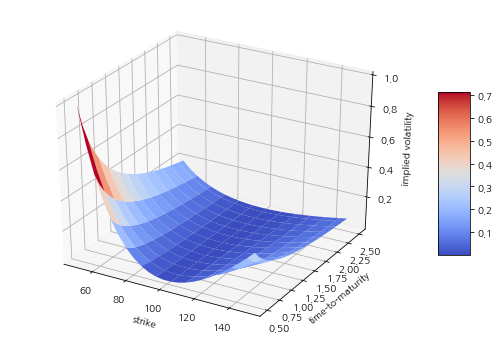

In [45]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(9, 6))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(strike, ttm, iv, rstride=2, cstride=2,
                       cmap=plt.cm.coolwarm, linewidth=0.5,
                       antialiased=True)

ax.set_xlabel('strike'); ax.set_ylabel('time-to-maturity')
ax.set_zlabel('implied volatility')
fig.colorbar(surf, shrink=0.5, aspect=5)

Text(0.5,0,'implied volatility')

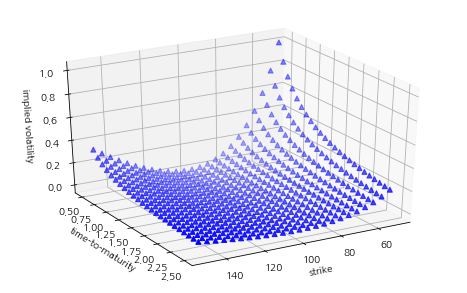

In [46]:
# 3d scatter plot 으로 변형 후, 바라보는 각도를 변환
fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(30, 60)        # 초기 각도값 설정
ax.scatter(strike, ttm, iv, zdir='z', s=25,
           c='b', marker='^')
ax.set_xlabel('strike'); ax.set_ylabel('time-to-maturity')
ax.set_zlabel('implied volatility')

<br>
# <strong> 4 병렬 연산처리 방법 (Chapter 8)
Performance Python
<br>
## <strong>1 IPyparallel 을 활용한 클러스터 병렬실행
https://ipython.org/ipython-doc/3/parallel/parallel_intro.html#getting-started

In [2]:
# from IPython.parallel import Client
from ipyparallel import Client
c = Client(profile='default')
view = c.load_balanced_view()

In [3]:
! ipcluster start -n 4            
# kernel 에서 클러스터를 활성화
# 실제 가속효과는 크게 없는 듯 해서 별로임

2018-01-02 11:17:49.399 [IPClusterStart] Starting ipcluster with [daemon=False]
2018-01-02 11:17:49.399 [IPClusterStart] Creating pid file: /home/markbaum/.ipython/profile_default/pid/ipcluster.pid
2018-01-02 11:17:49.399 [IPClusterStart] Starting Controller with LocalControllerLauncher
2018-01-02 11:17:50.402 [IPClusterStart] Starting 4 Engines with LocalEngineSetLauncher
^C
2018-01-02 11:18:19.074 [IPClusterStart] ERROR | IPython cluster: stopping
2018-01-02 11:18:19.075 [IPClusterStart] Stopping Engines...


In [8]:
%time
for i in range(1000000000):
    i += i
print(i)

CPU times: user 7 µs, sys: 0 ns, total: 7 µs
Wall time: 12.6 µs
1999999998


In [ ]:
from numba.cuda import